# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../input/frozen-dessert-production/Frozen_Dessert_Production.csv',
                 index_col='DATE',
                 parse_dates=True
                )
df

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [4]:
df.describe()

,IPN31152N
count,573.000
mean,109.896
std,27.951
min,58.660
25%,88.936
50%,107.643
75%,128.278
max,196.174


In [5]:
df.rename(columns={'IPN31152N':'Production'}, inplace=True)
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


<AxesSubplot:xlabel='DATE'>

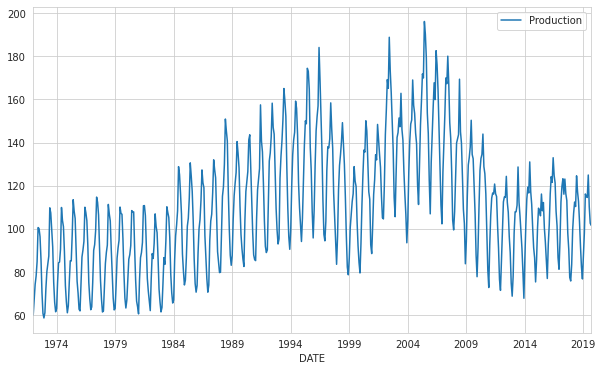

In [6]:
df.plot()

## Preprocessing of Data

### Train Test Split

In [7]:
len(df)

573

In [8]:
test_size = 24

In [9]:
test_ind = len(df)- test_size
test_ind

549

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
train

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2017-05-01,116.064
2017-06-01,123.087
2017-07-01,116.264


In [12]:
test

,Production
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490
2018-03-01,107.315
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584


### Scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler


In [14]:
scaler = MinMaxScaler()


In [15]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [18]:
len(generator)

537

In [19]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]),
 array([[0.01774221]]))

In [20]:
X, y = generator[0]

In [21]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Import related libraries

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Creating Model

In [23]:
n_features = train_scaled.shape[1]

## With "tanh" activation function

In [24]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

2022-03-20 18:03:28.352260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 18:03:28.447044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 18:03:28.448508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 18:03:28.451725: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [25]:
model.fit_generator(generator = generator, epochs = 5)

2022-03-20 18:03:31.020776: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-03-20 18:03:34.057106: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


537/537 [==============================] - 7s 5ms/step - loss: 0.0210
Epoch 2/5
537/537 [==============================] - 3s 5ms/step - loss: 0.0049
Epoch 3/5
537/537 [==============================] - 3s 5ms/step - loss: 0.0048
Epoch 4/5
537/537 [==============================] - 3s 6ms/step - loss: 0.0041
Epoch 5/5
537/537 [==============================] - 3s 5ms/step - loss: 0.0038


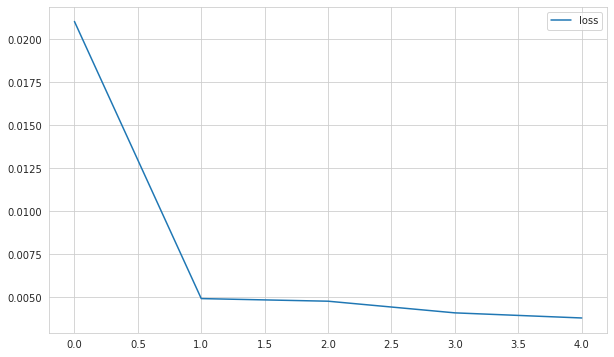

In [26]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot();

#### Evaluate on Test Data

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [28]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [29]:
test

,Production
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490
2018-03-01,107.315
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584


In [30]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [31]:
predictions_scaled

[array([0.2405419], dtype=float32),
 array([0.21913826], dtype=float32),
 array([0.24495184], dtype=float32),
 array([0.29704836], dtype=float32),
 array([0.35267338], dtype=float32),
 array([0.40078196], dtype=float32),
 array([0.43827185], dtype=float32),
 array([0.4583996], dtype=float32),
 array([0.45833477], dtype=float32),
 array([0.42357984], dtype=float32),
 array([0.3643075], dtype=float32),
 array([0.2934959], dtype=float32),
 array([0.24506421], dtype=float32),
 array([0.23184408], dtype=float32),
 array([0.25407434], dtype=float32),
 array([0.29754463], dtype=float32),
 array([0.3480115], dtype=float32),
 array([0.39562565], dtype=float32),
 array([0.43324575], dtype=float32),
 array([0.4537194], dtype=float32),
 array([0.44969103], dtype=float32),
 array([0.41655502], dtype=float32),
 array([0.35972983], dtype=float32),
 array([0.29664236], dtype=float32)]

In [32]:
test_scaled

array([[0.23134679],
       [0.13655347],
       [0.12472921],
       [0.18015997],
       [0.29691617],
       [0.35382169],
       [0.39102302],
       [0.37592272],
       [0.47940099],
       [0.42586022],
       [0.3928192 ],
       [0.32470899],
       [0.2434103 ],
       [0.17289089],
       [0.13163033],
       [0.20608099],
       [0.28689318],
       [0.41822681],
       [0.40948951],
       [0.40651527],
       [0.48213817],
       [0.37525952],
       [0.3195946 ],
       [0.31216335]])

#### Inverse Transformations and Comparing

In [33]:
predictions = scaler.inverse_transform(predictions_scaled)

In [34]:
predictions

array([[ 91.73765549],
       [ 88.79435741],
       [ 92.34408341],
       [ 99.50807849],
       [107.15729213],
       [113.77289027],
       [118.9282714 ],
       [121.69611591],
       [121.68720225],
       [116.90791601],
       [108.75714416],
       [ 99.01956495],
       [ 92.3595358 ],
       [ 90.54158397],
       [ 93.59855271],
       [ 99.57632227],
       [106.51621774],
       [113.06382619],
       [118.2371125 ],
       [121.05252521],
       [120.49856697],
       [115.94190498],
       [108.12765138],
       [ 99.45224825]])

In [35]:
test

,Production
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490
2018-03-01,107.315
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584


In [36]:
test['RNN_tanh'] = predictions

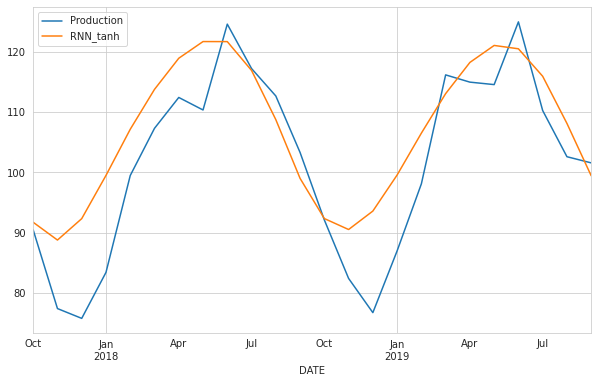

In [37]:
test.plot();

#### Calculation R2 Score and Error Metrics

In [38]:
eval_metrics(test.Production, test.RNN_tanh)

r2_score: 0.6792622108329178 
mae: 6.892878429031616 
mse: 70.98481026935717 
rmse: 8.42524838027682


## With "relu" activation function

In [39]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 100)           40800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit_generator(generator = generator, epochs = 5)

Epoch 1/5
537/537 [==============================] - 27s 48ms/step - loss: 0.0289
Epoch 2/5
537/537 [==============================] - 25s 47ms/step - loss: 0.0102
Epoch 3/5
537/537 [==============================] - 26s 48ms/step - loss: 0.0076
Epoch 4/5
537/537 [==============================] - 25s 47ms/step - loss: 0.0067
Epoch 5/5
537/537 [==============================] - 25s 47ms/step - loss: 0.0068


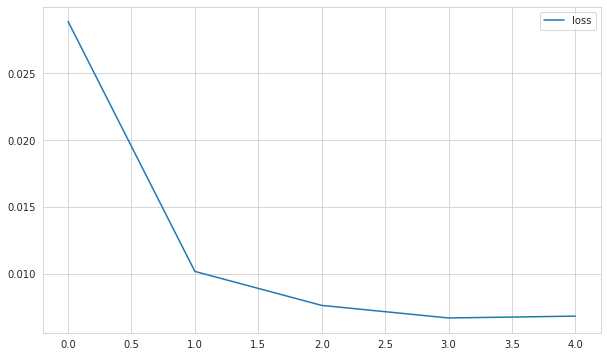

In [42]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot();

#### Evaluate on Test Data

In [43]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [44]:
predictions_scaled

[array([0.26747492], dtype=float32),
 array([0.17397603], dtype=float32),
 array([0.16720293], dtype=float32),
 array([0.25495818], dtype=float32),
 array([0.35606745], dtype=float32),
 array([0.40434045], dtype=float32),
 array([0.41826865], dtype=float32),
 array([0.42386046], dtype=float32),
 array([0.44464636], dtype=float32),
 array([0.4210282], dtype=float32),
 array([0.38756537], dtype=float32),
 array([0.2664601], dtype=float32),
 array([0.2152074], dtype=float32),
 array([0.1536909], dtype=float32),
 array([0.15825102], dtype=float32),
 array([0.23185575], dtype=float32),
 array([0.3206538], dtype=float32),
 array([0.36309382], dtype=float32),
 array([0.3871731], dtype=float32),
 array([0.41176298], dtype=float32),
 array([0.42859623], dtype=float32),
 array([0.41695496], dtype=float32),
 array([0.38222232], dtype=float32),
 array([0.23060817], dtype=float32)]

In [45]:
test_scaled

array([[0.23134679],
       [0.13655347],
       [0.12472921],
       [0.18015997],
       [0.29691617],
       [0.35382169],
       [0.39102302],
       [0.37592272],
       [0.47940099],
       [0.42586022],
       [0.3928192 ],
       [0.32470899],
       [0.2434103 ],
       [0.17289089],
       [0.13163033],
       [0.20608099],
       [0.28689318],
       [0.41822681],
       [0.40948951],
       [0.40651527],
       [0.48213817],
       [0.37525952],
       [0.3195946 ],
       [0.31216335]])

#### Inverse Transformations and Comparing

In [46]:
predictions = scaler.inverse_transform(predictions_scaled)

In [47]:
predictions

array([[ 95.44131934],
       [ 82.58392293],
       [ 81.65252763],
       [ 93.72009402],
       [107.62402356],
       [114.26223166],
       [116.17755342],
       [116.94650498],
       [119.80485488],
       [116.55702935],
       [111.95542614],
       [ 95.30176629],
       [ 88.2538086 ],
       [ 79.79443566],
       [ 80.42151457],
       [ 90.54318843],
       [102.75415406],
       [108.59024769],
       [111.90148109],
       [115.28293361],
       [117.59773889],
       [115.99690328],
       [111.22068252],
       [ 90.37162818]])

In [48]:
test

,Production,RNN_tanh
DATE,,
2017-10-01,90.473,91.738
2017-11-01,77.438,88.794
2017-12-01,75.812,92.344
2018-01-01,83.434,99.508
2018-02-01,99.490,107.157
2018-03-01,107.315,113.773
2018-04-01,112.431,118.928
2018-05-01,110.354,121.696
2018-06-01,124.584,121.687


In [49]:
test['RNN_relu'] = predictions

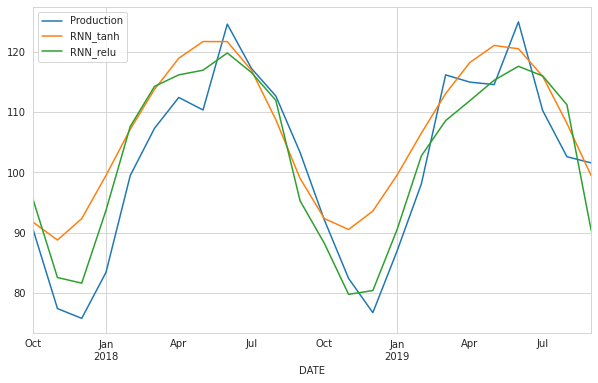

In [50]:
test.plot();

#### Calculation R2 Score and Error Metrics

In [51]:
eval_metrics(test.Production, test.RNN_relu)

r2_score: 0.8352782464440862 
mae: 5.354114052696463 
mse: 36.45576797722217 
rmse: 6.037861208840608


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [52]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [53]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [54]:
len(df)

573

In [55]:
len(generator)

561

In [56]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
561/561 [==============================] - 28s 47ms/step - loss: 0.0299
Epoch 2/15
561/561 [==============================] - 26s 46ms/step - loss: 0.0212
Epoch 3/15
561/561 [==============================] - 26s 47ms/step - loss: 0.0084
Epoch 4/15
561/561 [==============================] - 27s 47ms/step - loss: 0.0058
Epoch 5/15
561/561 [==============================] - 27s 49ms/step - loss: 0.0057
Epoch 6/15
561/561 [==============================] - 27s 48ms/step - loss: 0.0062
Epoch 7/15
561/561 [==============================] - 27s 48ms/step - loss: 0.0054
Epoch 8/15
561/561 [==============================] - 28s 49ms/step - loss: 0.0049
Epoch 9/15
561/561 [==============================] - 27s 47ms/step - loss: 0.0045
Epoch 10/15
561/561 [==============================] - 26s 46ms/step - loss: 0.0042
Epoch 11/15
561/561 [==============================] - 28s 50ms/step - loss: 0.0034
Epoch 12/15
561/561 [==============================] - 27s 47ms/step - loss: 0.0036
E

In [57]:
scaled_full_data.shape

(573, 1)

In [58]:
scaled_full_data[-length:].shape

(12, 1)

In [59]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [60]:
forecast = scaler.inverse_transform(forecast)

In [61]:
forecast

array([[ 90.55552821],
       [ 84.52247758],
       [ 83.57996172],
       [ 91.16157909],
       [102.17482367],
       [111.93220554],
       [117.83606346],
       [122.64478731],
       [124.57003089],
       [118.96485633],
       [111.18075753],
       [102.13816907]])

In [62]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [63]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')

In [64]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [65]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [66]:
forecast_df

,Forecast
2019-10-01,90.556
2019-11-01,84.522
2019-12-01,83.580
2020-01-01,91.162
2020-02-01,102.175
2020-03-01,111.932
2020-04-01,117.836
2020-05-01,122.645
2020-06-01,124.570
2020-07-01,118.965


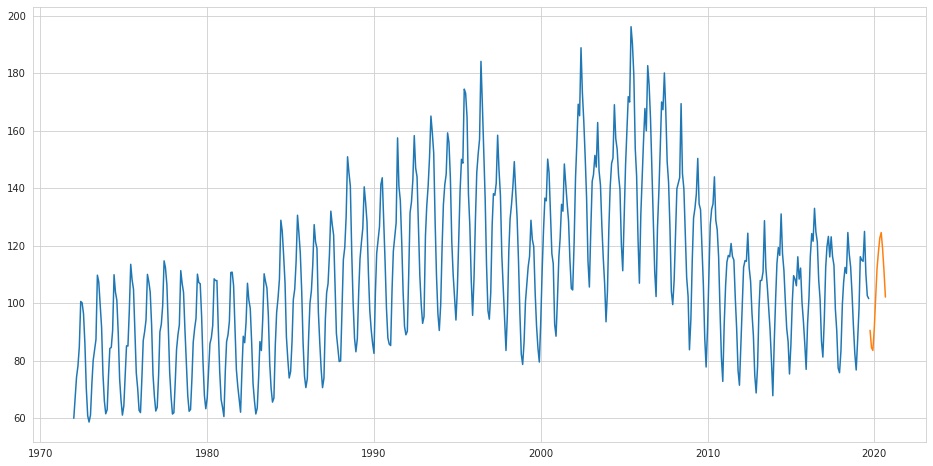

In [67]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Production'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

### Joining pandas plots

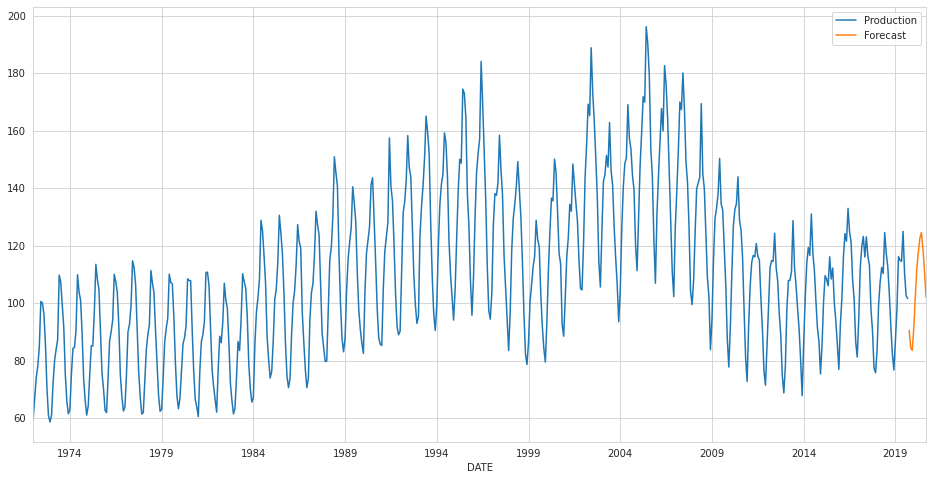

In [68]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 611.0)

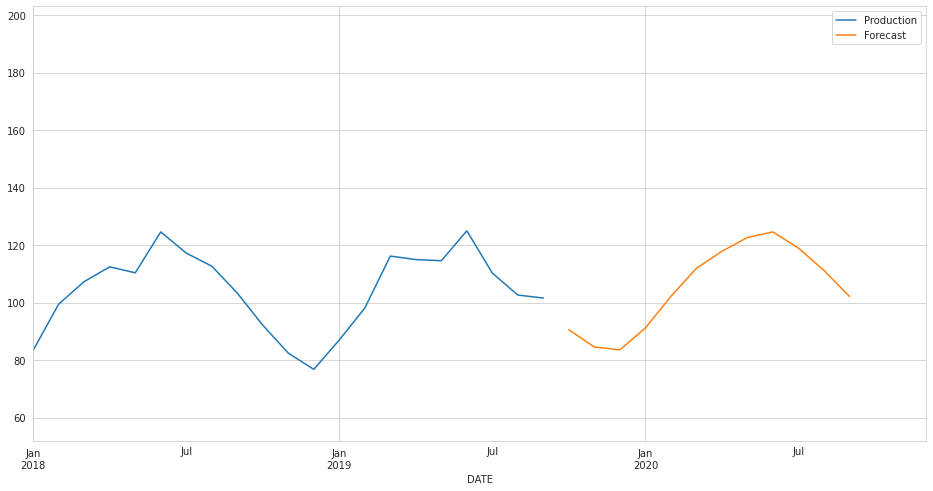

In [69]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')